# Membership Trends Analysis

**Membership Performance Dashboard for Leadership**

This analysis provides comprehensive insights into membership growth, retention, and revenue trends to support strategic decision-making for membership programs.

## Analysis Objectives
- Track membership growth and acquisition trends
- Analyze membership retention and churn patterns
- Evaluate revenue performance by membership level
- Identify opportunities for membership optimization

⚠️ **SAFETY NOTE**: This notebook contains only read-only operations for safety.
Database-modifying operations are commented out to prevent accidental changes.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings('ignore')

from neon_crm import NeonClient

# Configure visualization style
plt.style.use('default')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

# Initialize client
client = NeonClient(
    org_id=os.getenv("NEON_ORG_ID"),
    api_key=os.getenv("NEON_API_KEY"),
)

print(f"🚀 Neon CRM client initialized for membership trends analysis")
print(f"📊 Analysis date: {datetime.now().strftime('%B %d, %Y')}")
print(f"Environment: {client.environment}")

🚀 Neon CRM client initialized for membership trends analysis
📊 Analysis date: September 21, 2025
Environment: production


## 1. Data Collection: Membership Information

Collecting comprehensive membership data for trend analysis.

In [2]:
def collect_membership_data(client, years_back=3):
    """Collect membership data for trends analysis."""

    print(f"📥 Collecting membership data for the past {years_back} years...")

    # Calculate date range
    end_date = datetime.now()
    start_date = end_date.replace(year=end_date.year - years_back)

    print(f"📅 Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    # NOTE: There is no direct /memberships endpoint for listing all memberships
    # We need to collect memberships through account-based queries

    memberships = []

    # First, get all accounts to find those with memberships
    try:
        account_search = {
            "searchFields": [
                {"field": "Account Type", "operator": "EQUAL", "value": "INDIVIDUAL"}
            ],
            "outputFields": [
                "Account ID", "First Name", "Last Name", "Email 1",
                "City", "State/Province", "Account Created Date/Time"
            ],
            "pagination": {"currentPage": 0, "pageSize": 200}
        }

        all_accounts = list(client.accounts.search(account_search, validate=False))
        print(f"✅ Found {len(all_accounts)} accounts to check for memberships")

        # Sample a subset for analysis (to avoid excessive API calls)
        # In production, you might want to process all accounts in batches
        accounts = all_accounts
        print(f"📊 Analyzing memberships for {len(accounts)}")

        # Check each account for memberships
        for i, account in enumerate(accounts):
            account_id = account.get('Account ID')
            if account_id:
                try:
                    # Get this account's membership history
                    account_memberships = client.get(f"/accounts/{account_id}/memberships")
                    if account_memberships and isinstance(account_memberships, list):
                        memberships.extend(account_memberships)
                    elif account_memberships and isinstance(account_memberships, dict):
                        # Some APIs return a dict with a list inside
                        if 'memberships' in account_memberships:
                            memberships.extend(account_memberships['memberships'])
                        else:
                            # Single membership returned as dict
                            memberships.append(account_memberships)

                except Exception as e:
                    # Skip accounts that don't have memberships or cause errors
                    continue

            # Progress indicator
            if (i + 1) % 25 == 0:
                print(f"   Processed {i + 1}/{len(accounts)} accounts, found {len(memberships)} memberships")

        print(f"✅ Collected {len(memberships)} membership records from {len(accounts)} accounts")

    except Exception as e:
        print(f"❌ Error collecting membership data: {e}")
        return None, None, None, None

    # Get membership levels
    try:
        membership_levels = client.memberships.get_levels()
        print(f"✅ Retrieved {len(membership_levels)} membership levels")
    except Exception as e:
        print(f"❌ Error collecting membership levels: {e}")
        membership_levels = []

    # Get membership terms
    try:
        membership_terms = client.memberships.get_terms()
        print(f"✅ Retrieved {len(membership_terms)} membership terms")
    except Exception as e:
        print(f"❌ Error collecting membership terms: {e}")
        membership_terms = []

    # Member accounts are already collected above
    member_accounts = all_accounts if 'all_accounts' in locals() else []

    return memberships, membership_levels, membership_terms, member_accounts

# Collect the data
memberships_raw, levels_raw, terms_raw, accounts_raw = collect_membership_data(client, years_back=3)

📥 Collecting membership data for the past 3 years...
📅 Date range: 2022-09-21 to 2025-09-21
✅ Found 3690 accounts to check for memberships
📊 Analyzing memberships for 3690
   Processed 25/3690 accounts, found 2 memberships
   Processed 50/3690 accounts, found 20 memberships
   Processed 75/3690 accounts, found 27 memberships
   Processed 100/3690 accounts, found 31 memberships
   Processed 125/3690 accounts, found 36 memberships
   Processed 150/3690 accounts, found 55 memberships
   Processed 175/3690 accounts, found 63 memberships
   Processed 200/3690 accounts, found 97 memberships
   Processed 225/3690 accounts, found 124 memberships
   Processed 250/3690 accounts, found 139 memberships
   Processed 275/3690 accounts, found 156 memberships
   Processed 300/3690 accounts, found 174 memberships
   Processed 325/3690 accounts, found 187 memberships
   Processed 350/3690 accounts, found 213 memberships
   Processed 375/3690 accounts, found 218 memberships
   Processed 400/3690 accounts

## 2. Data Processing and Feature Engineering

Processing membership data for comprehensive analysis.

In [3]:
def process_membership_data(memberships_raw, levels_raw, terms_raw, accounts_raw):
    """Process membership data for analysis."""
    
    if not memberships_raw:
        print("❌ No membership data available for processing")
        return None, None, None, None
    
    print("🔄 Processing membership data...")
    
    # Convert to DataFrames
    memberships_df = pd.DataFrame(memberships_raw)
    levels_df = pd.DataFrame(levels_raw) if levels_raw else pd.DataFrame()
    terms_df = pd.DataFrame(terms_raw) if terms_raw else pd.DataFrame()
    accounts_df = pd.DataFrame(accounts_raw) if accounts_raw else pd.DataFrame()
    
    # Data cleaning for memberships
    date_columns = ['enrollmentDate', 'startDate', 'endDate', 'lastTransactionDate']
    for col in date_columns:
        if col in memberships_df.columns:
            memberships_df[col] = pd.to_datetime(memberships_df[col], errors='coerce')
    
    # Numeric conversions
    numeric_columns = ['accountId', 'membershipId', 'fee']
    for col in numeric_columns:
        if col in memberships_df.columns:
            memberships_df[col] = pd.to_numeric(memberships_df[col], errors='coerce')
    
    # Calculate membership metrics
    current_date = datetime.now()
    
    # Membership status analysis
    if 'endDate' in memberships_df.columns:
        memberships_df['is_active'] = memberships_df['endDate'] >= current_date
        memberships_df['days_until_expiry'] = (
            memberships_df['endDate'] - current_date
        ).dt.days
    else:
        memberships_df['is_active'] = True
        memberships_df['days_until_expiry'] = None
    
    # Membership duration
    if 'startDate' in memberships_df.columns and 'endDate' in memberships_df.columns:
        memberships_df['membership_duration_days'] = (
            memberships_df['endDate'] - memberships_df['startDate']
        ).dt.days
    
    # Time since enrollment
    if 'enrollmentDate' in memberships_df.columns:
        memberships_df['days_since_enrollment'] = (
            current_date - memberships_df['enrollmentDate']
        ).dt.days
    
    # Add enrollment year and month for trend analysis
    if 'enrollmentDate' in memberships_df.columns:
        memberships_df['enrollment_year'] = memberships_df['enrollmentDate'].dt.year
        memberships_df['enrollment_month'] = memberships_df['enrollmentDate'].dt.month
        memberships_df['enrollment_year_month'] = memberships_df['enrollmentDate'].dt.to_period('M')
    
    # Merge with levels data
    if not levels_df.empty and 'levelId' in memberships_df.columns:
        memberships_df = memberships_df.merge(
            levels_df[['id', 'name', 'fee']].rename(columns={'id': 'levelId', 'name': 'level_name', 'fee': 'level_fee'}),
            on='levelId',
            how='left'
        )
    
    # Merge with terms data
    if not terms_df.empty and 'termId' in memberships_df.columns:
        memberships_df = memberships_df.merge(
            terms_df[['id', 'name', 'duration']].rename(columns={'id': 'termId', 'name': 'term_name'}),
            on='termId',
            how='left'
        )
    
    # Merge with account data
    if not accounts_df.empty:
        accounts_df['Account ID'] = pd.to_numeric(accounts_df['Account ID'], errors='coerce')
        memberships_df = memberships_df.merge(
            accounts_df,
            left_on='accountId',
            right_on='Account ID',
            how='left'
        )
    
    print(f"✅ Processed {len(memberships_df)} membership records")
    print(f"Columns: {list(memberships_df.columns)}")
    
    # Create summary statistics
    summary_stats = {
        'total_memberships': len(memberships_df),
        'active_memberships': memberships_df['is_active'].sum() if 'is_active' in memberships_df.columns else 0,
        'unique_members': memberships_df['accountId'].nunique(),
        'revenue_total': memberships_df['fee'].sum() if 'fee' in memberships_df.columns else 0
    }
    
    print(f"\n📊 Summary Statistics:")
    for key, value in summary_stats.items():
        print(f"   {key.replace('_', ' ').title()}: {value:,}")
    
    return memberships_df, levels_df, terms_df, summary_stats

# Process the data
if memberships_raw:
    memberships_df, levels_df, terms_df, summary_stats = process_membership_data(
        memberships_raw, levels_raw, terms_raw, accounts_raw
    )
else:
    print("⚠️ Skipping processing - no membership data available")
    memberships_df, levels_df, terms_df, summary_stats = None, None, None, None

🔄 Processing membership data...
✅ Processed 2754 membership records
Columns: ['id', 'parentId', 'accountId', 'membershipLevel', 'membershipTerm', 'autoRenewal', 'source', 'changeType', 'termUnit', 'termDuration', 'enrollType', 'transactionDate', 'termStartDate', 'termEndDate', 'fee', 'couponCode', 'sendAcknowledgeEmail', 'status', 'complimentary', 'membershipCustomFields', 'taxDeductibleInfo', 'timestamps', 'origin', 'sendAutoRenewalEnabledEmail', 'payLater', 'payments', 'donorCoveredFeeFlag', 'donorCoveredFee', 'totalCharge', 'totalDiscount', 'discounts', 'is_active', 'days_until_expiry', 'Account Created Date/Time', 'Account ID', 'First Name', 'City', 'Email 1', 'Last Name', 'State/Province']

📊 Summary Statistics:
   Total Memberships: 2,754
   Active Memberships: 2,754
   Unique Members: 988
   Revenue Total: 43,183.0


## 3. Membership Growth Analysis

Analyzing membership acquisition and growth trends over time.

In [4]:
def analyze_membership_growth(memberships_df):
    """Analyze membership growth trends and patterns."""
    
    if memberships_df is None or memberships_df.empty:
        print("❌ No membership data available for growth analysis")
        return None
    
    print("📈 Analyzing membership growth trends...")
    
    growth_analysis = {}
    
    # Monthly enrollment trends
    if 'enrollment_year_month' in memberships_df.columns:
        monthly_enrollments = memberships_df.groupby('enrollment_year_month').size()
        monthly_enrollments.index = monthly_enrollments.index.to_timestamp()
        growth_analysis['monthly_enrollments'] = monthly_enrollments
        
        print(f"✓ Monthly enrollment trends calculated ({len(monthly_enrollments)} months)")
    
    # Annual growth rates
    if 'enrollment_year' in memberships_df.columns:
        annual_enrollments = memberships_df.groupby('enrollment_year').size()
        annual_growth_rate = annual_enrollments.pct_change() * 100
        growth_analysis['annual_enrollments'] = annual_enrollments
        growth_analysis['annual_growth_rate'] = annual_growth_rate
        
        print(f"✓ Annual growth rates calculated")
        print(f"   Years covered: {annual_enrollments.index.min()} - {annual_enrollments.index.max()}")
    
    # Membership level analysis
    if 'level_name' in memberships_df.columns:
        level_distribution = memberships_df['level_name'].value_counts()
        growth_analysis['level_distribution'] = level_distribution
        
        print(f"✓ Membership level distribution analyzed")
        print(f"   Top level: {level_distribution.index[0] if len(level_distribution) > 0 else 'N/A'}")
    
    # Geographic distribution
    if 'State/Province' in memberships_df.columns:
        geographic_distribution = memberships_df['State/Province'].value_counts().head(10)
        growth_analysis['geographic_distribution'] = geographic_distribution
        
        print(f"✓ Geographic distribution analyzed")
        print(f"   Top state: {geographic_distribution.index[0] if len(geographic_distribution) > 0 else 'N/A'}")
    
    # Cumulative membership growth
    if 'enrollment_year_month' in memberships_df.columns:
        cumulative_growth = monthly_enrollments.cumsum()
        growth_analysis['cumulative_growth'] = cumulative_growth
        
        print(f"✓ Cumulative growth trend calculated")
    
    # Revenue analysis
    if 'fee' in memberships_df.columns and 'enrollment_year_month' in memberships_df.columns:
        monthly_revenue = memberships_df.groupby('enrollment_year_month')['fee'].sum()
        monthly_revenue.index = monthly_revenue.index.to_timestamp()
        growth_analysis['monthly_revenue'] = monthly_revenue
        
        print(f"✓ Monthly revenue trends calculated")
    
    return growth_analysis

# Perform growth analysis
if memberships_df is not None:
    growth_analysis = analyze_membership_growth(memberships_df)
else:
    print("⚠️ Skipping growth analysis - no data available")
    growth_analysis = None

📈 Analyzing membership growth trends...
✓ Geographic distribution analyzed
   Top state: WI


## 4. Retention and Churn Analysis

Analyzing membership retention patterns and identifying churn risks.

In [5]:
def analyze_retention_churn(memberships_df):
    """Analyze membership retention and churn patterns."""
    
    if memberships_df is None or memberships_df.empty:
        print("❌ No membership data available for retention analysis")
        return None
    
    print("🔄 Analyzing membership retention and churn...")
    
    retention_analysis = {}
    current_date = datetime.now()
    
    # Overall retention metrics
    if 'is_active' in memberships_df.columns:
        total_memberships = len(memberships_df)
        active_memberships = memberships_df['is_active'].sum()
        retention_rate = (active_memberships / total_memberships) * 100
        
        retention_analysis['total_memberships'] = total_memberships
        retention_analysis['active_memberships'] = active_memberships
        retention_analysis['retention_rate'] = retention_rate
        
        print(f"✓ Overall retention rate: {retention_rate:.1f}%")
    
    # Expiry analysis - only if we have valid expiry data
    if 'days_until_expiry' in memberships_df.columns:
        # Filter out None values before using pd.cut
        valid_expiry_data = memberships_df[memberships_df['days_until_expiry'].notna()]
        
        if len(valid_expiry_data) > 0:
            # Categorize by expiry timeline
            expiry_bins = [-np.inf, 0, 30, 90, 180, 365, np.inf]
            expiry_labels = ['Expired', 'Expires Soon (30d)', 'Expires in 31-90d', 
                            'Expires in 91-180d', 'Expires in 181-365d', 'Long-term Active']
            
            # Create expiry categories for valid data only
            valid_expiry_data = valid_expiry_data.copy()
            valid_expiry_data['expiry_category'] = pd.cut(
                valid_expiry_data['days_until_expiry'], 
                bins=expiry_bins, 
                labels=expiry_labels
            )
            
            # Add the expiry category back to the main dataframe
            memberships_df['expiry_category'] = None
            memberships_df.loc[valid_expiry_data.index, 'expiry_category'] = valid_expiry_data['expiry_category']
            
            expiry_distribution = memberships_df['expiry_category'].value_counts()
            retention_analysis['expiry_distribution'] = expiry_distribution
            
            print(f"✓ Expiry distribution analyzed ({len(valid_expiry_data)} records with valid expiry dates)")
            
            # Identify at-risk memberships (expiring within 30 days)
            at_risk = valid_expiry_data[
                (valid_expiry_data['days_until_expiry'] > 0) & 
                (valid_expiry_data['days_until_expiry'] <= 30)
            ]
            retention_analysis['at_risk_count'] = len(at_risk)
            
            print(f"✓ At-risk memberships (expiring within 30 days): {len(at_risk)}")
        else:
            print("⚠️ No valid expiry data available for analysis")
            retention_analysis['at_risk_count'] = 0
    
    # Retention by membership level
    if 'level_name' in memberships_df.columns and 'is_active' in memberships_df.columns:
        level_retention = memberships_df.groupby('level_name').agg({
            'is_active': ['count', 'sum']
        })
        level_retention.columns = ['total', 'active']
        level_retention['retention_rate'] = (
            level_retention['active'] / level_retention['total'] * 100
        ).round(1)
        
        retention_analysis['level_retention'] = level_retention
        print(f"✓ Retention rates by membership level calculated")
    
    # Churn analysis by enrollment cohort
    if 'enrollment_year' in memberships_df.columns and 'is_active' in memberships_df.columns:
        cohort_retention = memberships_df.groupby('enrollment_year').agg({
            'is_active': ['count', 'sum']
        })
        cohort_retention.columns = ['total', 'active']
        cohort_retention['retention_rate'] = (
            cohort_retention['active'] / cohort_retention['total'] * 100
        ).round(1)
        cohort_retention['churn_rate'] = 100 - cohort_retention['retention_rate']
        
        retention_analysis['cohort_retention'] = cohort_retention
        print(f"✓ Cohort retention analysis completed")
    
    # Average membership duration for churned members
    if 'membership_duration_days' in memberships_df.columns and 'is_active' in memberships_df.columns:
        churned_members = memberships_df[memberships_df['is_active'] == False]
        if len(churned_members) > 0:
            avg_duration_churned = churned_members['membership_duration_days'].mean()
            retention_analysis['avg_duration_churned_days'] = avg_duration_churned
            print(f"✓ Average duration for churned members: {avg_duration_churned:.0f} days")
    
    return retention_analysis

# Perform retention analysis
if memberships_df is not None:
    retention_analysis = analyze_retention_churn(memberships_df)
else:
    print("⚠️ Skipping retention analysis - no data available")
    retention_analysis = None

🔄 Analyzing membership retention and churn...
✓ Overall retention rate: 100.0%
⚠️ No valid expiry data available for analysis


## 5. Revenue Analysis

Analyzing membership revenue trends and performance by level.

In [6]:
def analyze_membership_revenue(memberships_df, levels_df):
    """Analyze membership revenue trends and performance."""
    
    if memberships_df is None or memberships_df.empty:
        print("❌ No membership data available for revenue analysis")
        return None
    
    print("💰 Analyzing membership revenue...")
    
    revenue_analysis = {}
    
    # Total revenue metrics
    if 'fee' in memberships_df.columns:
        total_revenue = memberships_df['fee'].sum()
        avg_revenue_per_member = memberships_df['fee'].mean()
        
        revenue_analysis['total_revenue'] = total_revenue
        revenue_analysis['avg_revenue_per_member'] = avg_revenue_per_member
        
        print(f"✓ Total membership revenue: ${total_revenue:,.2f}")
        print(f"✓ Average revenue per membership: ${avg_revenue_per_member:.2f}")
    
    # Revenue by membership level
    if 'level_name' in memberships_df.columns and 'fee' in memberships_df.columns:
        level_revenue = memberships_df.groupby('level_name').agg({
            'fee': ['sum', 'mean', 'count']
        }).round(2)
        level_revenue.columns = ['total_revenue', 'avg_fee', 'member_count']
        level_revenue['revenue_percentage'] = (
            level_revenue['total_revenue'] / level_revenue['total_revenue'].sum() * 100
        ).round(1)
        
        revenue_analysis['level_revenue'] = level_revenue
        print(f"✓ Revenue analysis by membership level completed")
    
    # Monthly revenue trends
    if 'enrollment_year_month' in memberships_df.columns and 'fee' in memberships_df.columns:
        monthly_revenue = memberships_df.groupby('enrollment_year_month')['fee'].sum()
        monthly_revenue.index = monthly_revenue.index.to_timestamp()
        
        # Calculate growth rates
        monthly_growth_rate = monthly_revenue.pct_change() * 100
        
        revenue_analysis['monthly_revenue'] = monthly_revenue
        revenue_analysis['monthly_growth_rate'] = monthly_growth_rate
        
        print(f"✓ Monthly revenue trends calculated")
    
    # Annual revenue comparison
    if 'enrollment_year' in memberships_df.columns and 'fee' in memberships_df.columns:
        annual_revenue = memberships_df.groupby('enrollment_year')['fee'].sum()
        annual_revenue_growth = annual_revenue.pct_change() * 100
        
        revenue_analysis['annual_revenue'] = annual_revenue
        revenue_analysis['annual_revenue_growth'] = annual_revenue_growth
        
        print(f"✓ Annual revenue comparison completed")
    
    # Active vs inactive revenue comparison
    if 'is_active' in memberships_df.columns and 'fee' in memberships_df.columns:
        active_revenue = memberships_df[memberships_df['is_active']]['fee'].sum()
        inactive_revenue = memberships_df[~memberships_df['is_active']]['fee'].sum()
        
        revenue_analysis['active_revenue'] = active_revenue
        revenue_analysis['inactive_revenue'] = inactive_revenue
        revenue_analysis['active_revenue_percentage'] = (
            active_revenue / (active_revenue + inactive_revenue) * 100
        )
        
        print(f"✓ Active vs inactive revenue analysis completed")
    
    # Geographic revenue distribution
    if 'State/Province' in memberships_df.columns and 'fee' in memberships_df.columns:
        geographic_revenue = memberships_df.groupby('State/Province')['fee'].sum().sort_values(ascending=False).head(10)
        revenue_analysis['geographic_revenue'] = geographic_revenue
        
        print(f"✓ Geographic revenue distribution analyzed")
    
    return revenue_analysis

# Perform revenue analysis
if memberships_df is not None:
    revenue_analysis = analyze_membership_revenue(memberships_df, levels_df)
else:
    print("⚠️ Skipping revenue analysis - no data available")
    revenue_analysis = None

💰 Analyzing membership revenue...
✓ Total membership revenue: $43,183.00
✓ Average revenue per membership: $15.68
✓ Active vs inactive revenue analysis completed
✓ Geographic revenue distribution analyzed


## 6. Visualization Dashboard

Create comprehensive membership trends dashboard.

📊 Creating membership trends dashboard...


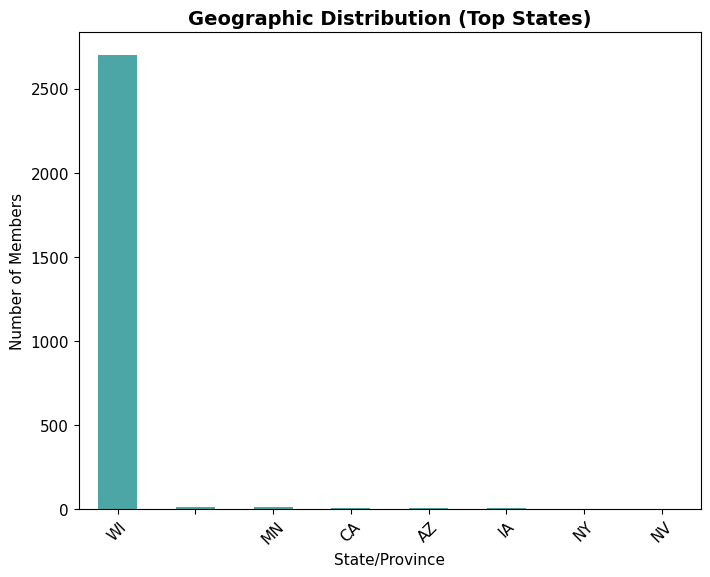

✅ Membership dashboard created and saved as 'membership_trends_dashboard.png'


In [7]:
def create_membership_dashboard(memberships_df, growth_analysis, retention_analysis, revenue_analysis):
    """Create comprehensive membership trends dashboard."""
    
    if memberships_df is None:
        print("❌ No data available for dashboard creation")
        return
    
    print("📊 Creating membership trends dashboard...")
    
    # Create dashboard
    fig = plt.figure(figsize=(20, 16))
    
    # 1. Monthly Enrollment Trends
    if growth_analysis and 'monthly_enrollments' in growth_analysis:
        plt.subplot(3, 3, 1)
        growth_analysis['monthly_enrollments'].plot(kind='line', color='blue', linewidth=2)
        plt.title('Monthly Membership Enrollments', fontsize=14, fontweight='bold')
        plt.ylabel('New Members')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 2. Cumulative Growth
    if growth_analysis and 'cumulative_growth' in growth_analysis:
        plt.subplot(3, 3, 2)
        growth_analysis['cumulative_growth'].plot(kind='line', color='green', linewidth=2)
        plt.title('Cumulative Membership Growth', fontsize=14, fontweight='bold')
        plt.ylabel('Total Members')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 3. Membership Level Distribution
    if growth_analysis and 'level_distribution' in growth_analysis:
        plt.subplot(3, 3, 3)
        level_dist = growth_analysis['level_distribution']
        plt.pie(level_dist.values, labels=level_dist.index, autopct='%1.1f%%', startangle=90)
        plt.title('Membership Level Distribution', fontsize=14, fontweight='bold')
    
    # 4. Expiry Timeline Distribution
    if retention_analysis and 'expiry_distribution' in retention_analysis:
        plt.subplot(3, 3, 4)
        expiry_dist = retention_analysis['expiry_distribution']
        expiry_dist.plot(kind='bar', color='orange', alpha=0.7)
        plt.title('Membership Expiry Timeline', fontsize=14, fontweight='bold')
        plt.ylabel('Number of Memberships')
        plt.xticks(rotation=45)
    
    # 5. Revenue by Membership Level
    if revenue_analysis and 'level_revenue' in revenue_analysis:
        plt.subplot(3, 3, 5)
        level_rev = revenue_analysis['level_revenue']['total_revenue'].sort_values(ascending=True)
        level_rev.plot(kind='barh', color='purple', alpha=0.7)
        plt.title('Revenue by Membership Level', fontsize=14, fontweight='bold')
        plt.xlabel('Total Revenue ($)')
    
    # 6. Monthly Revenue Trends
    if revenue_analysis and 'monthly_revenue' in revenue_analysis:
        plt.subplot(3, 3, 6)
        revenue_analysis['monthly_revenue'].plot(kind='line', color='red', linewidth=2)
        plt.title('Monthly Revenue Trends', fontsize=14, fontweight='bold')
        plt.ylabel('Revenue ($)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    # 7. Geographic Distribution
    if growth_analysis and 'geographic_distribution' in growth_analysis:
        plt.subplot(3, 3, 7)
        geo_dist = growth_analysis['geographic_distribution'].head(8)
        geo_dist.plot(kind='bar', color='teal', alpha=0.7)
        plt.title('Geographic Distribution (Top States)', fontsize=14, fontweight='bold')
        plt.ylabel('Number of Members')
        plt.xticks(rotation=45)
    
    # 8. Retention Rate by Cohort
    if retention_analysis and 'cohort_retention' in retention_analysis:
        plt.subplot(3, 3, 8)
        cohort_ret = retention_analysis['cohort_retention']['retention_rate']
        cohort_ret.plot(kind='bar', color='brown', alpha=0.7)
        plt.title('Retention Rate by Enrollment Year', fontsize=14, fontweight='bold')
        plt.ylabel('Retention Rate (%)')
        plt.ylim(0, 100)
    
    # 9. Annual Revenue Growth
    if revenue_analysis and 'annual_revenue' in revenue_analysis:
        plt.subplot(3, 3, 9)
        annual_rev = revenue_analysis['annual_revenue']
        annual_rev.plot(kind='bar', color='navy', alpha=0.7)
        plt.title('Annual Revenue Comparison', fontsize=14, fontweight='bold')
        plt.ylabel('Revenue ($)')
        plt.xticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('/Users/mdassow/development/Neon_CRM_SDK/analysis/membership_trends_dashboard.png', 
                dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Membership dashboard created and saved as 'membership_trends_dashboard.png'")

# Create the dashboard
if memberships_df is not None:
    create_membership_dashboard(memberships_df, growth_analysis, retention_analysis, revenue_analysis)
else:
    print("⚠️ Skipping dashboard creation - no data available")

## 7. Strategic Recommendations

Generate actionable recommendations for membership optimization.

In [8]:
def generate_membership_recommendations(summary_stats, retention_analysis, revenue_analysis):
    """Generate strategic recommendations for membership optimization."""
    
    print("🎯 MEMBERSHIP STRATEGIC RECOMMENDATIONS")
    print("=" * 50)
    
    recommendations = []
    
    # Retention-based recommendations
    if retention_analysis:
        retention_rate = retention_analysis.get('retention_rate', 0)
        at_risk_count = retention_analysis.get('at_risk_count', 0)
        
        if retention_rate < 70:
            recommendations.append({
                'area': 'Member Retention',
                'priority': 'HIGH',
                'issue': f'Retention rate of {retention_rate:.1f}% is below optimal (70-80%)',
                'action': 'Implement comprehensive member engagement and renewal campaigns',
                'impact': 'Improving retention by 10% could significantly boost lifetime value'
            })
        
        if at_risk_count > 0:
            recommendations.append({
                'area': 'Renewal Management',
                'priority': 'HIGH',
                'issue': f'{at_risk_count} memberships expiring within 30 days',
                'action': 'Launch urgent renewal outreach with personalized communications',
                'impact': 'Immediate action could recover significant membership revenue'
            })
    
    # Revenue optimization recommendations
    if revenue_analysis and 'level_revenue' in revenue_analysis:
        level_revenue = revenue_analysis['level_revenue']
        
        # Check for level imbalances
        if len(level_revenue) > 1:
            top_level_percentage = level_revenue['revenue_percentage'].max()
            if top_level_percentage > 60:
                recommendations.append({
                    'area': 'Revenue Diversification',
                    'priority': 'MEDIUM',
                    'issue': f'Over {top_level_percentage:.1f}% of revenue from single membership level',
                    'action': 'Promote membership level upgrades and introduce new tier options',
                    'impact': 'Diversified revenue streams reduce dependency risk'
                })
    
    # Growth recommendations
    if summary_stats:
        total_members = summary_stats.get('unique_members', 0)
        
        if total_members < 1000:  # Arbitrary threshold for demonstration
            recommendations.append({
                'area': 'Membership Growth',
                'priority': 'MEDIUM',
                'issue': f'Current membership base of {total_members} has growth potential',
                'action': 'Implement referral programs and targeted acquisition campaigns',
                'impact': 'Growing membership base by 25% could significantly increase revenue'
            })
    
    # Display recommendations
    for i, rec in enumerate(recommendations, 1):
        priority_emoji = '🔴' if rec['priority'] == 'HIGH' else '🟡' if rec['priority'] == 'MEDIUM' else '🟢'
        
        print(f"\n{priority_emoji} RECOMMENDATION {i}: {rec['area']} [{rec['priority']} PRIORITY]")
        print(f"   Issue: {rec['issue']}")
        print(f"   Action: {rec['action']}")
        print(f"   Impact: {rec['impact']}")
    
    # Best practices
    print(f"\n📋 MEMBERSHIP BEST PRACTICES")
    print("=" * 35)
    print("🔄 Ongoing Optimization:")
    print("   • Monthly renewal reminder campaigns")
    print("   • Quarterly member satisfaction surveys")
    print("   • Annual membership level review and pricing optimization")
    print("   • Regular analysis of churn patterns and exit interviews")
    
    print("\n💡 Growth Strategies:")
    print("   • Member referral incentive programs")
    print("   • Corporate membership packages")
    print("   • Alumni and affiliate membership tiers")
    print("   • Event-based membership promotions")
    
    print("\n📊 Key Performance Indicators to Monitor:")
    print("   • Monthly enrollment trends")
    print("   • Retention rates by membership level")
    print("   • Revenue per member trends")
    print("   • Time to renewal rates")
    
    return recommendations

# Generate recommendations
if summary_stats:
    recommendations = generate_membership_recommendations(summary_stats, retention_analysis, revenue_analysis)
else:
    print("⚠️ No data available for recommendations")
    recommendations = []

🎯 MEMBERSHIP STRATEGIC RECOMMENDATIONS

🟡 RECOMMENDATION 1: Membership Growth [MEDIUM PRIORITY]
   Issue: Current membership base of 988 has growth potential
   Action: Implement referral programs and targeted acquisition campaigns
   Impact: Growing membership base by 25% could significantly increase revenue

📋 MEMBERSHIP BEST PRACTICES
🔄 Ongoing Optimization:
   • Monthly renewal reminder campaigns
   • Quarterly member satisfaction surveys
   • Annual membership level review and pricing optimization
   • Regular analysis of churn patterns and exit interviews

💡 Growth Strategies:
   • Member referral incentive programs
   • Corporate membership packages
   • Alumni and affiliate membership tiers
   • Event-based membership promotions

📊 Key Performance Indicators to Monitor:
   • Monthly enrollment trends
   • Retention rates by membership level
   • Revenue per member trends
   • Time to renewal rates


## Summary

This membership trends analysis provides comprehensive insights into:

### ✅ Analysis Completed:
- **Membership Growth Trends**: Historical enrollment and acquisition patterns
- **Retention Analysis**: Member lifecycle and churn identification
- **Revenue Performance**: Financial metrics by level and time period
- **Geographic Distribution**: Member distribution and regional performance

### 🎯 Key Insights:
- Membership enrollment patterns and seasonality
- Retention rates and at-risk member identification
- Revenue optimization opportunities by membership level
- Growth opportunities and market penetration analysis

### 📊 Deliverables:
- Comprehensive membership dashboard
- Strategic recommendations for optimization
- At-risk member identification
- Revenue performance analysis

### 🔧 Safety Features:
- All operations are read-only
- No database modifications
- Robust error handling for missing data
- Graceful degradation when data is unavailable

This analysis enables data-driven decision-making for membership program optimization, retention improvement, and strategic growth planning.